In [19]:
import binascii
import time
import os
import shutil
import numpy
from fobos import openadc, projmgr, pynqctrl, nexys3dut
from pynq import Xlnk
import numpy as np
from pynq import Overlay
import sys
WORKSPACE       = "/home/xilinx/fobosworkspace"
#WORKSPACE      = "/mnt/nfs/fobosworkspace"
PROJECT_NAME    ="aes_test"
DIN_FILE_NAME   = "dinFile.txt"
CIPHER_FILE     = "do.txt"
TRACE_FILE      = "powerTraces.npy"
#DUT_BIT_FILE    = "half_duplex_dut.bit"
DUT_BIT_FILE    = "FOBOS_DUT.bit"
OUT_LEN         = 4
TRACE_NUM       = 10000
SAMPLING_FREQ   = 50
DUT_CLK         = 0.5
SAMPLE_NUM      = 2000


In [20]:
overlay = Overlay("ctrl_top_wrapper.bit")
fobosAcq = openadc.OpenADCScope(overlay)
fobosAcq.setAdcClockFreq(SAMPLING_FREQ)
fobosAcq.setGain(20)
xlnk = Xlnk()
outputBuffer = xlnk.cma_array(shape=(512,), dtype=np.uint64)


Set clk frequency to 50.0


In [21]:
##########################
###configure worksapce
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()
##########################
#configure controller
ctrl = pynqctrl.PYNQCtrl(overlay)
ctrl.setDUTClk(DUT_CLK)
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(pynqctrl.PYNQCtrl.TRG_FULL)
ctrl.setDUTInterface(pynqctrl.PYNQCtrl.INTERFACE_8BIT)
##########################
#configure DUT
dut = nexys3dut.Nexys3DUT()
bitFile = os.path.join(projDir, DUT_BIT_FILE)
dut.setBitFile(bitFile)
dut.program()

Set clk frequency to 0.5
Programming device using the following commands:
sudo -u xilinx djtgcfg init -d Nexys3
sudo -u xilinx djtgcfg prog -d Nexys3 -i 0 -f /home/xilinx/fobosworkspace/aes_test/FOBOS_DUT.bit
b'Programming device. Do not touch your board. This may take a few minutes...\nProgramming succeeded.\n'


In [24]:

##########################
#setup i/o files
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
#print("Copying test-vector file to attempt directory ...")
#shutil.copy(tvFileName, captureDir)
#########################
print("Loading test-vector file ...")
testVectors = tvFile.readlines()
print("Done loading.")
tic = time.time()
#traces = np.empty((TRACE_NUM, SAMPLE_NUM))
for traceNum in range(TRACE_NUM):
    fobosAcq.arm(outputBuffer,int(SAMPLE_NUM / 4))
    result = ctrl.processData(testVectors[traceNum])
    fobosAcq.waitForTrace()
    #change data typy before saving
    trace = outputBuffer.view('uint16')
    trace= trace[:SAMPLE_NUM]
    #traces[traceNum, :] = trace
    cipherFile.write(result + '\n')
    numpy.save(traceFile, trace)
    if traceNum % 1000 == 0:
        sys.stdout.write("Progress: {}%\r".format(traceNum/TRACE_NUM *100 ))
        sys.stdout.flush()
#numpy.save(traceFile,traces)
#traces = None #Free memory
cipherFile.close()
tvFile.close()
traceFile.close()
    
toc = time.time()
print("Time elapsed = {} seconds.".format(toc - tic))

Loading test-vector file ...
Done loading.
Time elapsed = 57.29441833496094 seconds.


/home/xilinx/fobosworkspace/aes_test/capture/attempt-249/powerTrace.npy
(2000,)


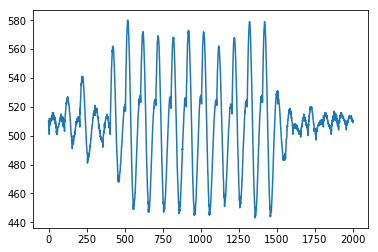

In [25]:
import matplotlib.pyplot as plt
f = open(traceFileName, 'rb')
print(traceFileName)
dataToPlot = numpy.load(f)
plt.plot(dataToPlot)
print(dataToPlot.shape)
plt.show()

In [5]:
traces = None